# Preservação de Privacidade na detecção de fraudes financeiras utilizando técnicas de Aprendizado Federado
## Pós-Graduação em Deep Learning (CIn - UFPE) - Trabalho Final do Curso  
------

**Aluno:** Luís Eduardo Lima Barbosa

**Dataset**: [Link](https://www.kaggle.com/datasets/ealaxi/paysim1)

**Framework**: [TensorFlow Federated](https://tensorflow.org/federated)

-----

Notebook com o código-fonte do projeto de detecção de fraudes financeiras utilizando Federated Learning (FL).

# Importando Recursos

In [1]:
# !pip install --quiet --upgrade tensorflow-federated imblearn

In [2]:
import tensorflow_federated as tff
import kagglehub
from os import path
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.data import Dataset
import dp_accounting
import seaborn as sns
from imblearn.over_sampling import SMOTE
import random
import time

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 428, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

In [3]:
ds_path = kagglehub.dataset_download('ealaxi/paysim1')

df = pd.read_csv(path.join(ds_path, 'PS_20174392719_1491204439457_log.csv'))
df.head(14)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


# Análise Exploratória do Dataset



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data_type = df['type'].value_counts()
data_type

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [6]:
df['type'].value_counts().sort_values(ascending=False)

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [7]:
fig = px.pie(data_type, values=data_type.values, names=data_type.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

<ipython-input-8-328fe8ef834b>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='type', ylabel='count'>

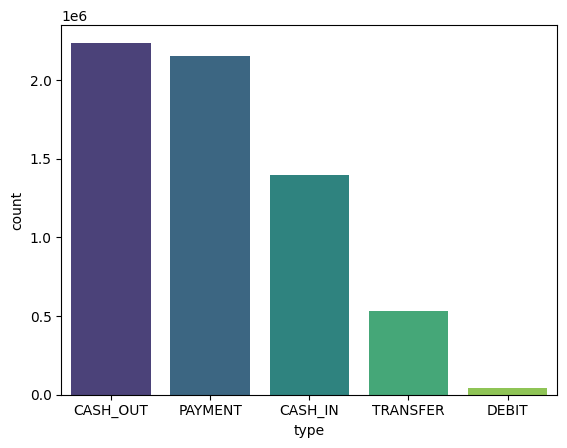

In [8]:
sns.countplot(data=df,x='type',palette='viridis',order=df["type"].value_counts().index)

In [9]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


<Axes: ylabel='count'>

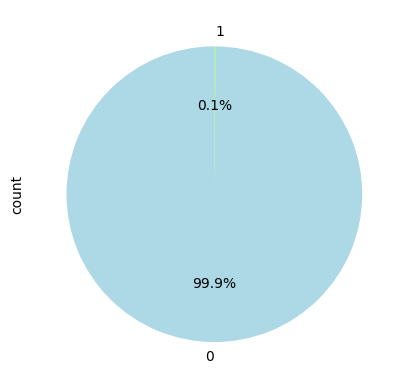

In [10]:
df['isFraud'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors = ['#add8e6', '#90ee90'])

## Análise da quantidade de registros de fraude por tipo

In [11]:
df[df['type']=='TRANSFER']['isFraud'].value_counts()

,count
isFraud,
0,528812
1,4097


In [12]:
df[df['type']=='CASH_OUT']['isFraud'].value_counts()

,count
isFraud,
0,2233384
1,4116


In [13]:
df.groupby(['type', 'isFraud']).size().unstack()

isFraud,0,1
type,,
CASH_IN,1399284.0,NaN
CASH_OUT,2233384.0,4116.0
DEBIT,41432.0,NaN
PAYMENT,2151495.0,NaN
TRANSFER,528812.0,4097.0


# Pré-processamento dos dados

In [4]:
NUMBER_OF_CLIENTS = 30
AVAILABILITY_RATE = 0.6
NUMBER_OF_ROUNDS = 30
CLIENTS_PER_ROUND = 8
BATCH_SIZE = 8

## Remoção de colunas não utilizadas no treinamento

In [5]:
df = df.drop(['isFlaggedFraud', 'nameOrig', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)
# mantendo apenas os tipos que possuem registros marcados como fraude
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2770409 entries, 2 to 6362619
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   step     int64  
 1   type     object 
 2   amount   float64
 3   isFraud  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 105.7+ MB


In [7]:
df['type'].value_counts()

,count
type,
CASH_OUT,2237500
TRANSFER,532909


In [8]:
c = df['type'].astype('category')
df['type'] = c.cat.codes
df['type'] = df['type'].astype('int8')
df['step'] = df['step'].astype('int16')
df['isFraud'] = df['isFraud'].astype('int8')

## Aplicação de estratégias de *resampling* com SMOTE


In [9]:
# Resampling com SMOTE devido ao baixo número de transações do dataset marcadas como fraude
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

print(f'Número de linhas marcadas como normais após resample: {sum(y_sm == 0)}')
print(f'Número de linhas marcadas como fraude após resample: {sum(y_sm == 1)}')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Número de linhas marcadas como normais após resample: 2762196
Número de linhas marcadas como fraude após resample: 2762196


In [10]:
X_sm.reset_index(drop=True, inplace=True)
y_sm.reset_index(drop=True, inplace=True)

df = pd.concat([X_sm, y_sm], axis=1)

print(df.tail())

counting_frauds = df['isFraud'].value_counts()

print(f'Número de linhas marcadas como normais: {counting_frauds[0]}')
print(f'Número de linhas marcadas como fraude: {counting_frauds[1]}')

         step  type        amount  isFraud
5524387    62     0  7.244144e+05        1
5524388   293     0  8.935347e+04        1
5524389   171     0  1.415032e+05        1
5524390   343     0  1.504844e+06        1
5524391   527     0  6.274281e+06        1
Número de linhas marcadas como normais: 2762196
Número de linhas marcadas como fraude: 2762196


## Divisão dos conjuntos de treino e teste

In [11]:
# Para agilizar o treinamento do modelo, vamos trabalhar com apenas 40% do dataset.
sampled_df = df.sample(frac=0.4)

In [12]:
split_idx = int(len(sampled_df) * 0.8)
train_df = sampled_df[:split_idx]
test_df = sampled_df[split_idx:]

print(f'{len(train_df)} transações para treino')
print(f'{len(test_df)} transações para teste')

1767805 transações para treino
441952 transações para teste


In [13]:
x_train = train_df.drop(['isFraud'], axis=1)
y_train = train_df['isFraud']

x_test = test_df.drop(['isFraud'], axis=1)
y_test = test_df['isFraud']

In [14]:
fd_test_data = tf.data.Dataset.from_tensor_slices((x_test[:len(test_df)], y_test[:len(test_df)])).batch(BATCH_SIZE)

# Definição do cliente

In [15]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id

    def get_dataset(self):
        return self.dataset

In [37]:
def create_client_data(pointer, clientlist):
    shuffle_size = len(x_train) + len(y_train)
    list_index = len(clientlist)
    radical = (len(x_train) // NUMBER_OF_CLIENTS)
    partition_size = int(radical * random.uniform(0.6, 1.0))

    if list_index == NUMBER_OF_CLIENTS:
        return

    start = pointer
    next = start + partition_size
    end =  next - 1

    print(f'Cliente {list_index}: Linhas {start} a {end}.')
    dataset = tf.data.Dataset.from_tensor_slices((x_train[start:end], y_train[start:end])).shuffle(shuffle_size).batch(BATCH_SIZE)
    clientlist.append(Client('cliente_' + str(list_index), dataset))
    create_client_data(next, clientlist)

In [21]:
def load_client_datasets():
    return create_client_data(0, [])

# Definição do servidor

In [18]:
def get_federated_model(input_spec):
    input_shape = input_spec[0].shape[1:]
    target_shape = (input_shape[0], 1)

    model = tf.keras.Sequential()
    model.add(Reshape(target_shape=target_shape, input_shape=input_shape))
    model.add(Conv1D(filters=16, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return tff.learning.models.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

In [19]:
def get_aggregation_factory(noise_multiplier):
    return tff.learning.model_update_aggregator.dp_aggregator(
        noise_multiplier, CLIENTS_PER_ROUND
    )

In [20]:
def build_fed_avg(input_spec, noise_multiplier):
    return tff.learning.algorithms.build_unweighted_fed_avg(
        model_fn=lambda: get_federated_model(input_spec),
        client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.01),
        server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0, momentum=0.9),
        model_aggregator=get_aggregation_factory(noise_multiplier)
    )

# Execução do treinamento

In [38]:
client_sets = load_client_datasets()

Cliente 0: Linhas 0 a 37304.
Cliente 1: Linhas 37305 a 74602.
Cliente 2: Linhas 74603 a 126572.
Cliente 3: Linhas 126573 a 183424.
Cliente 4: Linhas 183425 a 225706.
Cliente 5: Linhas 225707 a 282061.
Cliente 6: Linhas 282062 a 333954.
Cliente 7: Linhas 333955 a 381018.
Cliente 8: Linhas 381019 a 422499.
Cliente 9: Linhas 422500 a 469491.
Cliente 10: Linhas 469492 a 508544.
Cliente 11: Linhas 508545 a 550615.
Cliente 12: Linhas 550616 a 596051.
Cliente 13: Linhas 596052 a 653753.
Cliente 14: Linhas 653754 a 705492.
Cliente 15: Linhas 705493 a 755723.
Cliente 16: Linhas 755724 a 804685.
Cliente 17: Linhas 804686 a 857770.
Cliente 18: Linhas 857771 a 901435.
Cliente 19: Linhas 901436 a 940912.
Cliente 20: Linhas 940913 a 998793.
Cliente 21: Linhas 998794 a 1042122.
Cliente 22: Linhas 1042123 a 1082469.
Cliente 23: Linhas 1082470 a 1139845.
Cliente 24: Linhas 1139846 a 1177353.
Cliente 25: Linhas 1177354 a 1224861.
Cliente 26: Linhas 1224862 a 1274517.
Cliente 27: Linhas 1274518 a 1318096

In [25]:
input_spec = client_sets[0].get_dataset().element_spec

## Treinamento da variação de ruído

### Definido os valores iniciais do treinamento pelo servidor

In [32]:
available_clients = random.sample(client_sets, int(NUMBER_OF_CLIENTS * AVAILABILITY_RATE))

In [33]:
print('Clientes disponíveis:')
for client in available_clients:
  print('- ', client.get_client_id())

Clientes disponíveis:
-  cliente_25
-  cliente_1
-  cliente_2
-  cliente_5
-  cliente_23
-  cliente_7
-  cliente_26
-  cliente_27
-  cliente_19
-  cliente_17
-  cliente_9
-  cliente_24
-  cliente_28
-  cliente_8
-  cliente_6
-  cliente_18
-  cliente_11
-  cliente_3


In [35]:
def train(noise_multiplier):
  iterative_process = build_fed_avg(
    input_spec=input_spec,
    noise_multiplier=noise_multiplier
  )

  server_state = iterative_process.initialize()

  data_frame = pd.DataFrame()
  state = server_state
  for i in range(1, NUMBER_OF_ROUNDS + 1):
    state, metrics = iterative_process.next(state, [client.get_dataset() for client in available_clients])
    if i % 3 != 0:
      continue

    rd_metrics = metrics['client_work']['train']
    print('Rodada {:2d}, métricas={}'.format(i, rd_metrics))
    temp_df = pd.DataFrame({'Rodada': [i], 'NoiseMultiplier': [noise_multiplier], **{k: [v] for k, v in rd_metrics.items()}}, index=[0])
    data_frame = pd.concat([data_frame, temp_df], ignore_index=True)

  eval_process = tff.learning.algorithms.build_fed_eval(model_fn=lambda: get_federated_model(input_spec))
  eval_state = eval_process.initialize()
  model_weights = iterative_process.get_model_weights(state)
  eval_process.set_model_weights(eval_state, model_weights)
  validation = eval_process.next(eval_state, [fd_test_data])
  return data_frame, validation.metrics['client_work']['eval']

### Executa o treinamento alterando o ruído

In [36]:
df_metrics = pd.DataFrame()
df_eval_metrics = pd.DataFrame()
time_metrics = []

for noise in [0.0, 0.25, 0.5, 0.75]:
  print(f'Treinando com ruído de {noise}\n')
  start = time.time()
  train_metrics, val_metrics = train(noise)
  end = time.time()
  execution_time = end - start
  time_metrics.append({'noise': noise, 'execution_time': execution_time})
  print(f'Tempo de execução: {execution_time} segundos\n')
  df_metrics = pd.concat([df_metrics, train_metrics], ignore_index=True)
  df_eval_metrics = pd.concat([df_eval_metrics, pd.DataFrame(val_metrics, index=[0])], ignore_index=True)

Treinando com ruído de 0.0

Rodada  3, métricas=OrderedDict([('binary_accuracy', 0.5000611), ('loss', 7.690309), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada  6, métricas=OrderedDict([('binary_accuracy', 0.4998993), ('loss', 7.688528), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada  9, métricas=OrderedDict([('binary_accuracy', 0.50031114), ('loss', 7.6732087), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 12, métricas=OrderedDict([('binary_accuracy', 0.5001275), ('loss', 7.69085), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 15, métricas=OrderedDict([('binary_accuracy', 0.50006413), ('loss', 7.693317), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 18, métricas=OrderedDict([('binary_accuracy', 0.50007087), ('loss', 7.669406), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 21, métricas=OrderedDict([('binary_accuracy', 0.50061435), ('loss', 6.7090707), ('num_examples', 2651688), ('num_batches', 331470)])
R

/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/aggregators/differential_privacy.py:95: UserWarning:

A significant amount of noise (2.87x) has to be added for record aggregation to achieve the desired effective `noise_multiplier` (0.75). If you are manually specifying `clipped_count_stddev` you may want to increase it. Or you may need more `expected_clients_per_round`.



Rodada  3, métricas=OrderedDict([('binary_accuracy', 0.5003217), ('loss', 7.692787), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada  6, métricas=OrderedDict([('binary_accuracy', 0.49992496), ('loss', 7.7022734), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada  9, métricas=OrderedDict([('binary_accuracy', 0.5001112), ('loss', 7.6891913), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 12, métricas=OrderedDict([('binary_accuracy', 0.5002911), ('loss', 7.6939235), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 15, métricas=OrderedDict([('binary_accuracy', 0.50135046), ('loss', 7.6778173), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 18, métricas=OrderedDict([('binary_accuracy', 0.50119096), ('loss', 7.676294), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 21, métricas=OrderedDict([('binary_accuracy', 0.5007897), ('loss', 7.673595), ('num_examples', 2651688), ('num_batches', 331470)])
Rodada 24, métricas=Ordered

## Treinamento de disponibilidade variável de clientes

In [26]:
NOISE_MULTIPLIER = 0.25

In [27]:
def train_available_clients(clients, rate):
  iterative_process = build_fed_avg(
    input_spec=input_spec,
    noise_multiplier=NOISE_MULTIPLIER
  )

  server_state = iterative_process.initialize()

  data_frame = pd.DataFrame()
  state = server_state
  for i in range(1, NUMBER_OF_ROUNDS + 1):
    state, metrics = iterative_process.next(state, [client.get_dataset() for client in clients])
    if i % 3 != 0:
      continue

    rd_metrics = metrics['client_work']['train']
    print('Rodada {:2d}, métricas={}'.format(i, rd_metrics))
    temp_df = pd.DataFrame({'Rodada': [i], 'AvailableClients': [rate], **{k: [v] for k, v in rd_metrics.items()}}, index=[0])
    data_frame = pd.concat([data_frame, temp_df], ignore_index=True)

  eval_process = tff.learning.algorithms.build_fed_eval(model_fn=lambda: get_federated_model(input_spec))
  eval_state = eval_process.initialize()
  model_weights = iterative_process.get_model_weights(state)
  eval_process.set_model_weights(eval_state, model_weights)
  validation = eval_process.next(eval_state, [fd_test_data])
  return data_frame, validation.metrics['client_work']['eval']

In [28]:
df_availability_metrics = pd.DataFrame()
time_availability_metrics = []

for rate in [0.25, 0.5, 0.75, 1.0]:
  print(f'Treinando com {int(rate * 100)}% de disponibilidade de clientes\n')
  available_clients = random.sample(client_sets, int(NUMBER_OF_CLIENTS * rate))

  start = time.time()
  train_metrics, val_metrics = train_available_clients(available_clients, rate)

  end = time.time()
  execution_time = end - start
  time_availability_metrics.append({'availability': rate, 'execution_time': execution_time})
  print(f'Tempo de execução: {execution_time} segundos\n')
  df_availability_metrics = pd.concat([df_availability_metrics, train_metrics], ignore_index=True)

Treinando com 25% de disponibilidade de clientes

Rodada  3, métricas=OrderedDict([('binary_accuracy', 0.50121343), ('loss', 7.6632743), ('num_examples', 412475), ('num_batches', 51562)])
Rodada  6, métricas=OrderedDict([('binary_accuracy', 0.5013637), ('loss', 7.677984), ('num_examples', 412475), ('num_batches', 51562)])
Rodada  9, métricas=OrderedDict([('binary_accuracy', 0.49899265), ('loss', 7.7147336), ('num_examples', 412475), ('num_batches', 51562)])
Rodada 12, métricas=OrderedDict([('binary_accuracy', 0.5006025), ('loss', 7.6838655), ('num_examples', 412475), ('num_batches', 51562)])
Rodada 15, métricas=OrderedDict([('binary_accuracy', 0.50157946), ('loss', 7.680851), ('num_examples', 412475), ('num_batches', 51562)])
Rodada 18, métricas=OrderedDict([('binary_accuracy', 0.498966), ('loss', 7.719604), ('num_examples', 412475), ('num_batches', 51562)])
Rodada 21, métricas=OrderedDict([('binary_accuracy', 0.5005758), ('loss', 7.7030354), ('num_examples', 412475), ('num_batches', 5

# Resultados

In [29]:
def plot_accuracy_graph(df_plot, hue):
  plt.figure(figsize=(10, 6))

  sns.lineplot(x='Rodada', y='Acurácia', data=df_plot, hue=hue, palette='dark')
  plt.title('Acurácia x Rodada')

  plt.show()

In [30]:
def plot_loss_graph(df_plot, hue):
  plt.figure(figsize=(10, 6))

  sns.lineplot(x='Rodada', y='Perda', data=df_plot, hue=hue, palette='dark')
  plt.title('Perda x Rodada')

  plt.show()

## Plotagem dos gráficos do treinamento de multiplicação de ruído

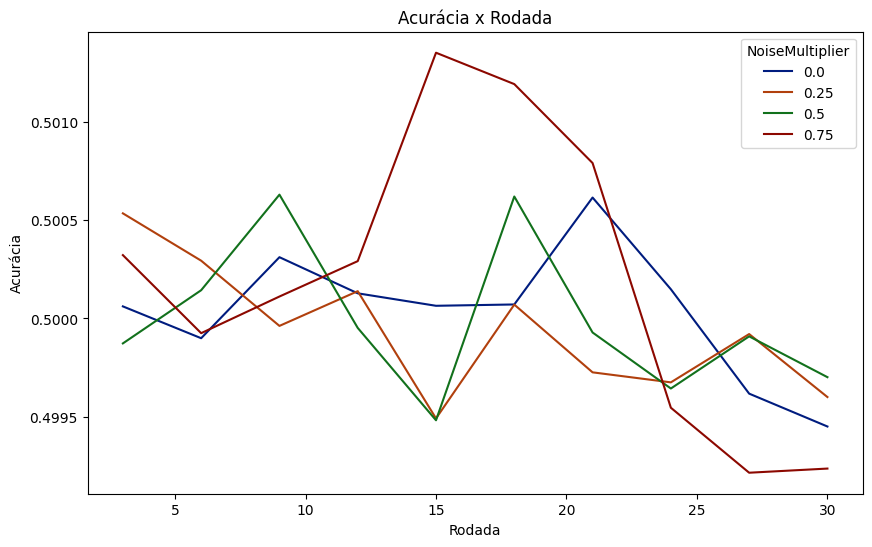

In [43]:
dataframe = df_metrics.rename(columns={'binary_accuracy': 'Acurácia', 'loss': 'Perda'})
plot_accuracy_graph(dataframe, 'NoiseMultiplier')

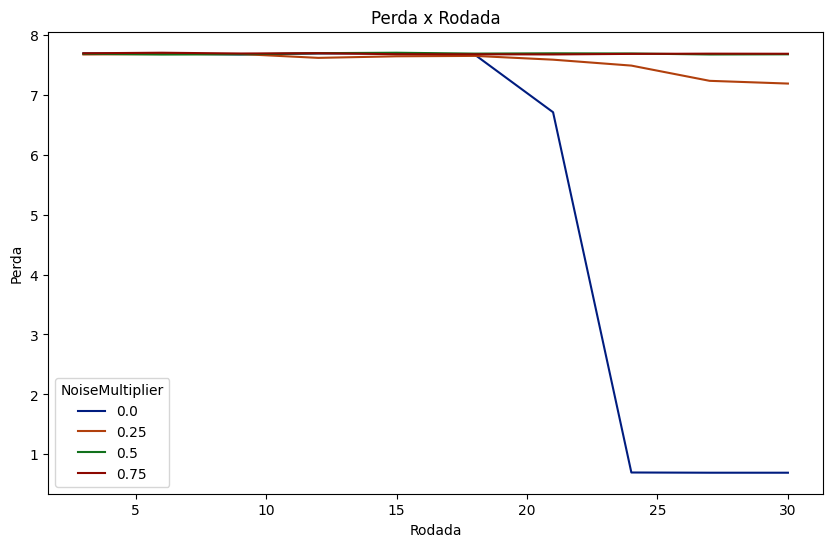

In [44]:
plot_loss_graph(dataframe, 'NoiseMultiplier')

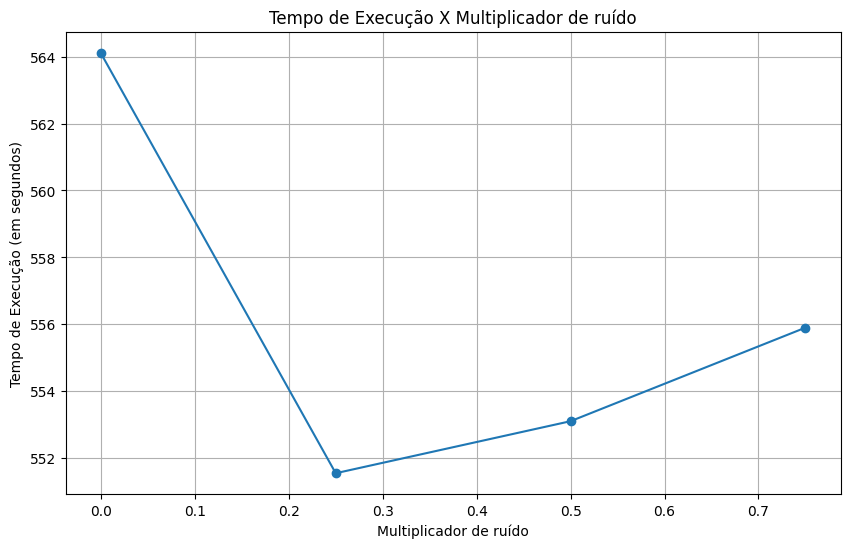

In [45]:
time_metrics_df = pd.DataFrame(time_metrics)

plt.figure(figsize=(10, 6))
plt.plot(time_metrics_df['noise'], time_metrics_df['execution_time'], marker='o')
plt.xlabel('Multiplicador de ruído')
plt.ylabel('Tempo de Execução (em segundos)')
plt.title('Tempo de Execução X Multiplicador de ruído')
plt.grid(True)
plt.show()


## Plotagem dos gráficos do treinamento de disponibilidade dos clientes

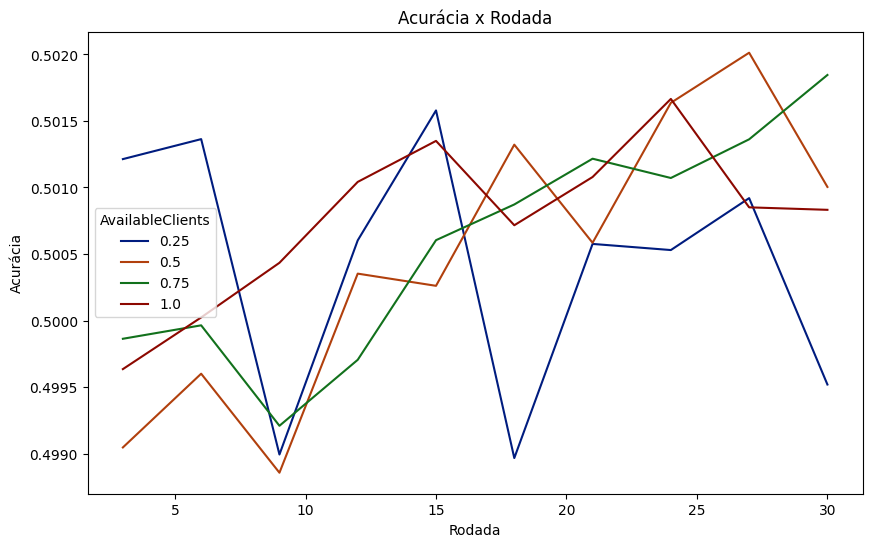

In [31]:
dataframe_clients = df_availability_metrics.rename(columns={'binary_accuracy': 'Acurácia', 'loss': 'Perda'})
plot_accuracy_graph(dataframe_clients, 'AvailableClients')

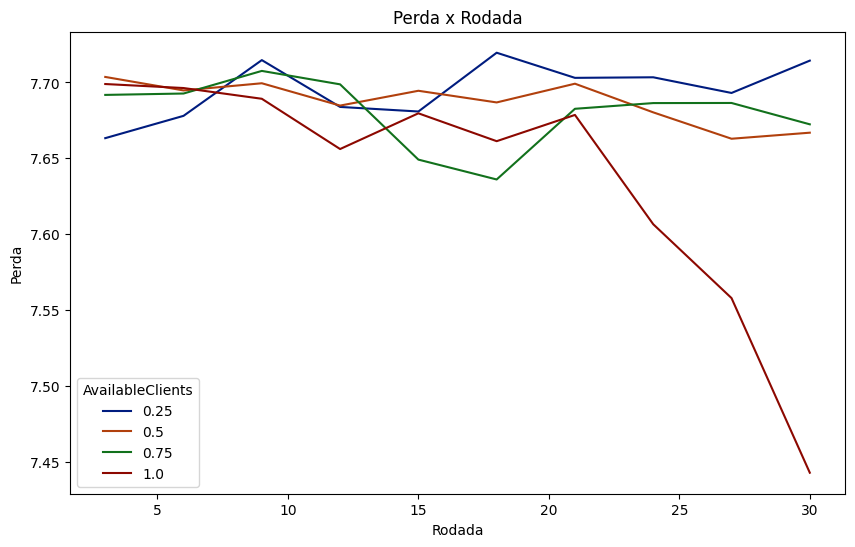

In [32]:
plot_loss_graph(dataframe_clients, 'AvailableClients')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   availability    4 non-null      float64
 1   execution_time  4 non-null      float64
dtypes: float64(2)
memory usage: 196.0 bytes
None


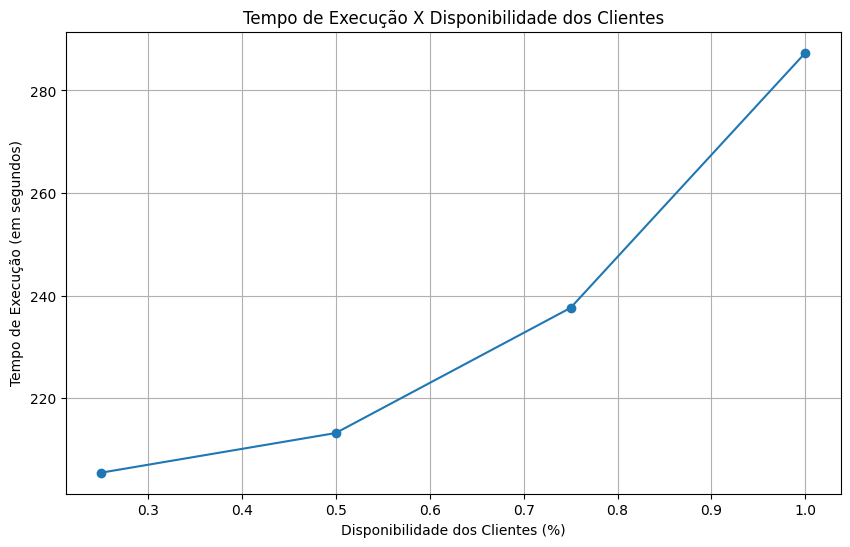

In [33]:
time_availability_metrics_df = pd.DataFrame(time_availability_metrics)
print(time_availability_metrics_df.info())
plt.figure(figsize=(10, 6))
plt.plot(time_availability_metrics_df['availability'], time_availability_metrics_df['execution_time'], marker='o')
plt.xlabel('Disponibilidade dos Clientes (%)')
plt.ylabel('Tempo de Execução (em segundos)')
plt.title('Tempo de Execução X Disponibilidade dos Clientes')
plt.grid(True)
plt.show()